In [1]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

Requirements for this assignment:
- Code needs to be dynamic
- Must read in a csv file containing a finite number of stock tickers (with an example csv file in this repo)
- Portfolio must contain only US listed stocks
- Must have an average daily volume of at least 10 000 shares as calculated based on the time interval July 2, 2021 to October 22, 2021
- Pick a minimum 10 maximum 20 stocks for portfolio.
- If we choose n stocks, each stock must make up minimum (100/(2n))% of the portfolio when weighted by value as of closing prices on November 26, 2021
- No individual stock may make up more than 35% of the portfolio when weighted by value
- We have 100000 USD to spend on portfolio and all must be spent
- When code is run with the .csv file, it must create a DataFrame "FinalPortfolio"
    - With this portfolio, index starts at 1 and ends at the number of stocks that our code chooses.
    - Headings must be: Ticker, Price, Shares, Value, Weight
        - Ticker is the ticker selected
        - Price is the price on November 26, 2021
        - Shares is the number of shares purchased (can be fractional)
        - Value is the total value of those shares
        - Weighted is the weight that the value of shares represents relative to the value of the portfolio (which is 100,000)
    - Needs to show that the total adds up to 100,000
    - Also need to show the weights add to 100%
    - This DataFrame must be printed to the screen as the second to last output to the screen.
- After the DataFrame, one final DataFrame called "Stocks" which has the same index as "Final Portfolio" must be made
    - Only has the Tickers and Shares from "Final Portfolio"
    - Must output this DataFrame to a csv file titled "Stocks_Group_XX.csv"

## **General Strategy**:

#### Preparation
0) Define given variables and other imporant global variables.

#### Part #1: Data Cleansing and Filtering
1) Filter out all valid US Stocks from the provided CSV file.
2) Store the price and volume info of tickers in global dataframe.
3) Filter out tickers within date range based on daily average volume.

#### Part #2: Portfolio Construction
4) Obtain the 20 most volatile stocks (based on Standard Deviation).
5) Find the porfolio of 10 stocks with the highest correlation.
6) STEP 6: Find the distributions of the weight that maximizes portfolio Standard Deviation.

#### Part #3: Proof and Analysis
7) Graph the portfolio standard deviation for different weighting distributions.
8) Given the chosen portfolio, measure its performance against the price weighted index consisting of all filtered US Stocks.
9) Given the chosen portfolio of 10 stocks, graph the change in portfolio standard deviation as other stocks are added
10) Beta in reference to the S&P 500.
11) Calculate the Beta between our portfolio and an equally weighted portfolio including all valid stocks.
12) Beta in reference to the price-weighted index of given stocks
13) Beta between our portfolio with varied weight versus when it is equally weighted
14) Compare our portfolio graphically against an equally weighted index containing only the 10 stocks chosen

#### Part #4: Final Output
15) Creating the final portfolio dataframe and CSV.

## Part #1: Data Cleansing and Filtering


### Step #0: Define important default and global variables (optimizing time and memories)
We will define a global variable 'all_price_df' that tracks the daily closing price and daily volume of all valid US stocks. Many functions will directly access this global dataframe during calculations, to avoid the inefficient passing large dataframes as parameters.

**NOTE** that all calculations will be performed with data from the daily interval, since first of all, data is very limited, thus not supporting calculation with dispersed interval. Yet, most importantly, the competition is held only for  a couple of days, therefore gauging the historical daily fluctuation of stocks better serves the purpose for this specific project.

In [2]:
# Import default information
start_date = '2021-07-02'
end_date = '2021-10-23' # So that 2021-10-22 is included in the data
provided_csv = 'Tickers.csv'
initial_investment = 1000000
min_avg_daily_volume = 10000
min_stock_count = 10
max_stock_count = 20

# Stores all valid US tickers as yfObjects!!!!
us_stock_lst = []

# Stores the closing price and volume of tickers
all_price_df = pd.DataFrame()

### Step #1: Filter out valid US tickers
Use the threading technique to quickly filter out all valid US stock in the given CSV.

In [3]:
stocks_from_csv = pd.read_csv(provided_csv, header=None) # Use header=Noned to read in the first row
stocks_lst = stocks_from_csv.iloc[:,0]
stocks_lst = stocks_lst.unique().tolist() # Take only the unique values, remove duplicates

In [4]:
# import the modules needed for threading
import concurrent.futures

# Clears the global variable in case of previous stored info (when re-executing cells)
us_stock_lst = []

# Add valid stocks to the us_stock_lst
def filter_valid(ticker_name):
    try:
        ticker_yf = yf.Ticker(ticker_name) # Store as variable to optimize access time
        if (ticker_yf.info['regularMarketPrice'] != None) and (ticker_yf.info['market'] == 'us_market'):
            us_stock_lst.append(ticker_yf)

    except requests.exceptions.RequestException as e:
       return e
 
# Function to call threading
def runner():
    threads= []
    with concurrent.futures.ThreadPoolExecutor(max_workers=80) as executor:
        for name in stocks_lst:
            threads.append(executor.submit(filter_valid, name))

# Calls function, us_stock_lst will be filled
runner()

In [5]:
# A quick check of the content in the us_stock_lst
len(us_stock_lst)

55

### Step #2: Store the price and volume info of tickers in global dataframe

Use threading to store the daily closing price and daily volume of all valid US ticker to global dataframe 'all_price_df'.

In [6]:
# Find the data of a particularly stock
def ticker_to_df(ticker_yf):
    # Access the ticker symbol of the ticker
    symbol = ticker_yf.info['symbol']

    # If the ticker is not yet included, we return its info
    if symbol not in all_price_df:
        temp_df = ticker_yf.history(start=start_date, end=end_date)[['Close', 'Volume']]
        temp_df = temp_df.rename(columns={'Close' : symbol, 'Volume' : f'{symbol}_Vol'})
        return temp_df
    # Otherwise return an empty dataframe, so all_price_df will not be changed
    return pd.DataFrame()

# Use threading to update the global price dataframe
def update_price_df(ticker_lst):
    with concurrent.futures.ThreadPoolExecutor(max_workers=80) as executor:
        results = executor.map(ticker_to_df, us_stock_lst)

    # Load in the global dataframe
    global all_price_df

    # Update the global dataframe based on the statistic info of each ticker
    for result in results:
        all_price_df = pd.concat([all_price_df, result], axis=1)

In [7]:
# Call the function to fill all_price_df
update_price_df(us_stock_lst)

# A quick check of the content in the all_price_df
all_price_df.tail()

,BA,BA_Vol,MON,MON_Vol,AAPL,AAPL_Vol,BAC,BAC_Vol,AIG,AIG_Vol,...,CSCO,CSCO_Vol,USB,USB_Vol,GM,GM_Vol,LMT,LMT_Vol,BK,BK_Vol
Date,,,,,,,,,,,,,,,,,,,,,
2021-10-18,216.979996,6553500,9.78,141200,146.550003,85589200,46.279999,49542500,57.889999,3299000,...,55.189999,10989600,60.580002,5212200,56.889999,12667900,365.000000,1014600,57.081612,5218900
2021-10-19,215.970001,5963400,9.78,0,148.759995,76378900,46.480000,32515500,58.639999,3217200,...,55.740002,13258400,61.349998,3506800,56.849998,10589000,371.070007,1051300,57.320240,5765200
2021-10-20,216.169998,8485200,9.75,1800,149.259995,58418800,47.090000,40411000,59.610001,3205000,...,56.200001,11613600,62.580002,4806200,57.669998,13399900,371.130005,955200,58.970745,6276100
2021-10-21,214.339996,8691500,9.75,0,149.479996,61421000,46.830002,36848600,59.259998,2794600,...,55.689999,12619900,62.180000,4699000,58.410000,11585400,373.140015,803600,59.398285,4178100
2021-10-22,212.970001,7077600,9.76,2300,148.690002,58883400,47.570000,36225600,60.009998,3734100,...,55.110001,15026600,62.740002,5251100,57.770000,11077600,374.600006,1092000,59.368454,4978500


### Step #3: Filter out tickers within date range based on daily average volume

Iterates through each ticker in the 'us_stock_lst' and check if they are valid. Access the daily volume in 'all_price_df'.

In [8]:
# Finds the average daily volume of a stock
def avg_daily_volume(ticker):
    # Load the global price dataframe
    global all_price_df

    # Calculate and return the average volume
    return all_price_df[f'{ticker}_Vol'].mean()
    
# Iterates through us_stock_lst and checks if the stock has
# an average daily volume of at least the minimum given
def volume_filter():
    # Define a list to store the valid tickers
    valid_stock_list = []

    # Find the ticker that meets the criteria
    for i in us_stock_lst:
        symbol = i.info['symbol']

        # Skip tickers that are listed after the start_date or delisted before the end_date
        if all_price_df[symbol].isnull().values.any():
            continue # Skip this ticker
        # Filter based on average daily volumne
        elif avg_daily_volume(i.info['symbol']) >= min_avg_daily_volume:
            valid_stock_list.append(i)
        
    
    # Return all valid stocks
    return valid_stock_list

# Find the stocks that meet the criteria
filtered_stocks = volume_filter()

In [9]:
# A quick check of the content in the filtered_stocks
len(filtered_stocks)

55

## Part #2: Portfolio Construction

### Step #4: Obtain the 20 most volatile stocks (based on Standard Deviation) 
Calculate the Standard Deviation of the returns of each stock in 'filtered_stocks' and find the 20 with the highest Standard Deviation. The parameter of 20 is specifically chosen since the maximum number of stocks to be included in a portfolio is 20, and thus we wish to only consider the most volatile 20 stocks (though not all will be included in the final portfolio).

In [10]:
# Variable to store the number of most volatile stocks we wish to find
volatile_sample = max_stock_count

# ticker_lst will always be filtered_stocks in yfObjects
def find_volatile (stock_count, ticker_lst): 
    # Load in global price df
    global all_price_df

    # Find the list of filtered symbols
    ticker_symbol = []
    for i in ticker_lst:
        ticker_symbol.append(i.info['symbol'])

    share_prices = all_price_df[ticker_symbol]

    #Convert our dataframe into simply one column with standard deviation 
    sd_of_shares = share_prices.pct_change().std()

    #Have to convert sd_of_shares into a dataframe
    sd_df = pd.DataFrame(sd_of_shares)

    #Find the 20 largest standard deviations meaning the most volatile
    column = sd_df[0]
    largest_names = []
    for i in range (stock_count):
        largest_names.append(column.idxmax())
        column = column.drop([column.idxmax()])

    return largest_names

largest_volatile = find_volatile(volatile_sample, filtered_stocks)

# Display
print('The top 20 volatile tickers are:\n', largest_volatile)

The top 20 volatile tickers are:
 ['OXY', 'SLB', 'GM', 'COP', 'COF', 'BA', 'PYPL', 'AIG', 'SPG', 'AXP', 'BIIB', 'BAC', 'USB', 'BK', 'KMI', 'CAT', 'MS', 'AMZN', 'PFE', 'C']


### Step #5: Find the portfolio of 10 stocks with the highest correlation
Take the first 15 (or all if there is less than 15) volatile stocks, and iterate through all portfolio combinations of 10 stocks to find the portfolio with the highest average correlation.

The average correlation is simply the average value of each pair-wise correlation of the stocks in a portfolio. This helps us to find a portfolio that is highly correlated, apart from being very volatile. Thus, the volatility in each stock will not cancel out, for instance, when one stock fluctuates in an upward trend and the other in the opposite direction.

The rationale behind taking only the first 15 tickers is that first of all, we want tickers that are very volatile. More importantly, this helps to reduce computation time. Specifically, choosing a portfolio of 10 tickers from 15 tickers would yield 3003 combinations (15 choose 10). On other hand, if we choose a portfolio of 10 from all 20 tickers would require 184756 combinations (20 choose 10), which takes a lot more time.

In [11]:
### Find all possible combinations of n tickers within the ticker_lst using a recursive function
def combinations(arr, length, pre_arr=[]):
    # If the store arr reaches the length required, return it
    if len(pre_arr) == length:
        return [pre_arr]
    
    combs = []
    # Add each element to the previous array
    for i in range (len(arr)):
        cur_copy = pre_arr.copy()
        cur_copy.append(arr[i])
        # Find combinations that yields by adding the remaining ticker spots to stored array of chosen tickers
        combs += combinations(arr[i+1:], length, cur_copy)
    return combs

In [12]:
# Find the correlation matrix of all 20 stocks
price_df = all_price_df[largest_volatile]
price_df = price_df[(start_date <= price_df.index) & (price_df.index <= end_date)]
df_corr = price_df.corr()

# Function that finds the average correlation between stocks in a given portfolio
def find_avg_corr(ticker_lst):   
    # Calculate the avg corr
    sum_corr = 0
    sum_count = 0
    # Iterate through the pair_wise correlation and summing it up
    for i in range (len(ticker_lst)):
        for j in range (i+1, len(ticker_lst)):
            sum_corr += df_corr.loc[ticker_lst[i],ticker_lst[j]]
            sum_count += 1
    
    # Calculate the return the avg correlation
    return (sum_corr/sum_count)


In [13]:
# Find the combinaton of tickers with the maximum avg correlation
def find_max_correlation(ticker_lst, result_size = min_stock_count):
    # Store the maximum value of corr and the portfolio
    max_avg_corr = -1
    max_corr_ticker_lst = np.array([])
    
    # Load the global price dataframe
    global all_price_df
    
    # Convert list to array and find the combinations
    comb = combinations(np.array(ticker_lst), result_size)
        
    # Find the comb with the maximum average correlation
    for i in comb:
        avg_corr = find_avg_corr(i)
        if avg_corr > max_avg_corr:
            max_avg_corr = avg_corr
            max_corr_ticker_lst = i
    
    # Return the result sample
    return max_avg_corr, max_corr_ticker_lst

In [14]:
# Take the first 15 most volatile stocks, or all if there is not enough for 15
take_ticker_up_to = min(len(largest_volatile), 15) 
ticker_lst = largest_volatile[0 : take_ticker_up_to]

# Find the combination of tickers with maximum correlation
max_avg_corr, max_corr_ticker_lst = find_max_correlation(ticker_lst)

# Display
print('The maximum avg correlation is:', max_avg_corr)
print('The portfolio with maximum avg correlation is:', max_corr_ticker_lst)

The maximum avg correlation is: 0.6184563708330199
The portfolio with maximum avg correlation is: ['OXY', 'SLB', 'COP', 'COF', 'AIG', 'SPG', 'AXP', 'BAC', 'USB', 'BK']


### Step #6: Find the distributions of the weight that maximizes portfolio Standard Deviation

Use an exhaustive method of finding the optimal weighting, that is to test many combinations of weighting and find the one with the highest Portfolio Standard Deviation.

First, we vary the weighting by increments from the min_weight to the max_weight. Our default 'number_of_increment' will be 8 for a suitable computation time.

Moreover, we only vary the weighting of the first 5 (stored in 'varied_count') volatile tickers, and the remaining tickers will have a default weighting of min_weight. The number of combinations of weighting is equal to the varied_count to the power of number_of_increment. Therefore, only varying the first 5 yields a total of 5^8 = 390625 combinations, which is far faster than varying all 10 weightings, which takes 10^8 = 100000000.

In [15]:
### Define important variables
ticker_count = len(max_corr_ticker_lst) # Should be 10
varied_count = int(ticker_count / 2) # Should be 5
min_weight = 1/(2*ticker_count) 
max_weight = 0.35
number_of_increment = 8
increment = (max_weight - min_weight)/number_of_increment

In [16]:
### Define a function for calculation of portfolio Standard Deviation
def portfolio_cal(tickers, weights, start_date, end_date, investment=100000):
    # Load the global variable price dataframe
    global all_price_df
    
    # Store the size of tickers as a variable
    ticker_count = len(tickers)
    
    # Store the price information of the tickers in a new df
    port_df = all_price_df[(start_date <= all_price_df.index) & (all_price_df.index <= end_date)][tickers]
    
    # Find the value of each ticker using the shares brought on the first date
    for i in range (ticker_count):
        shares = (investment * weights[i] / port_df.loc[start_date, tickers[i]])
        port_df[tickers[i]] = port_df[tickers[i]] * shares

    # Calculate the portfolio value
    port_df['Portfolio_Value'] = port_df[tickers].sum(axis=1)

    # Calculate percentage returns
    port_df['Percent_Return'] = port_df['Portfolio_Value'].pct_change() * 100

    # Calculate and return the portfolio standard deviation
    return port_df[['Portfolio_Value', 'Percent_Return']]

In [17]:
# Define variables
all_std = []
max_std = -1
optimal_weights = []
check_count = 0

# Recursion: update max_std with the maximum recorded std, and fill in the list of all_std
def find_weight(cur_index, weights, remaining_weight):
    # Load global varables
    global ticker_count, varied_count, all_std, max_std, optimal_weights, check_count
    
    # Already assigned last ticker's weights
    if (cur_index == ticker_count):
        if (remaining_weight != 0): return

        # Display for confirmation that code works
        check_count += 1
        if (check_count % 1000 == 0): 
            print(f'Already Checked {check_count} Weighting Distributions.')

        # Calculate portfolio Std
        port_df = portfolio_cal(max_corr_ticker_lst, weights, start_date, end_date)
        std = port_df['Percent_Return'].std()
        
        # Store and find max std
        all_std.append(std)
        if (std > max_std):
            max_std = std
            optimal_weights = weights
        
        # End recursion since this is last index (aka last ticker to assign weights)
        return
    
    # The weight for the remaining ticker will not be varied
    if (cur_index >= varied_count):
        find_weight(cur_index + 1, weights + [min_weight], remaining_weight)
    # ELSE: assign weighting for this stock at the cur_index
    else: 
        # Store the extra weight given to this stock beyond the minimum weight
        cur_extra_weight = 0

        # Make sure the extra_weight will not cause to stock to excess max_weight
        while (cur_extra_weight <= max_weight - min_weight):
            # Stores the weight given to the current ticker, starts at min_weight
            ticker_weight = min_weight

            # Check if the extra weight given will exceed the remaining distributable weights
            if (cur_extra_weight > remaining_weight):
                ticker_weight += remaining_weight

                # Recursively calls the function to assign weights for the next ticker
                find_weight(cur_index + 1, weights + [ticker_weight], 0)
                break
        
            # ELSE: extra weight does not exceed the remaining weight to be distributed
            ticker_weight += cur_extra_weight
            
            # Recursively calls the function to assign weights for the next ticker
            find_weight(cur_index + 1, weights + [ticker_weight], remaining_weight - cur_extra_weight)

            # Increments for next iteration
            cur_extra_weight += increment

In [18]:
# Find the best weighting distribution, should only take 30 to 60 seconds
find_weight(0, [], 1 - ticker_count * (min_weight))

Already Checked 1000 Weighting Distributions.
Already Checked 2000 Weighting Distributions.
Already Checked 3000 Weighting Distributions.


In [19]:
# Display of results
print('The highest recorded std is', max_std)
print('The ticker in the portfolio and corresponding weights:')
max_corr_ticker_lst, optimal_weights

The highest recorded std is 2.115425751221299
The ticker in the portfolio and corresponding weights:


(['OXY', 'SLB', 'COP', 'COF', 'AIG', 'SPG', 'AXP', 'BAC', 'USB', 'BK'],
 [0.35, 0.25, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

## Part #3: Proof and Analysis


### Step #7: Graph the Portfolio Standard Deviation for different weighting distributions

We will graph all the recorded Portfolio Standard Deviation in a histogram to show how volatile the portfolio would be if its weights are distributed otherwise.

**NOTE:** This graph should exhibit a normal distribution (higher frequency in the middle; less on the sides). Therefore, if the weight is chosen randomly, it is very unlikely that the Portfolio Standard Deviation is maximized. This proves that the exhaustive method of weighting distribution is necessary to find the best portfolio, as outlined by the red line.

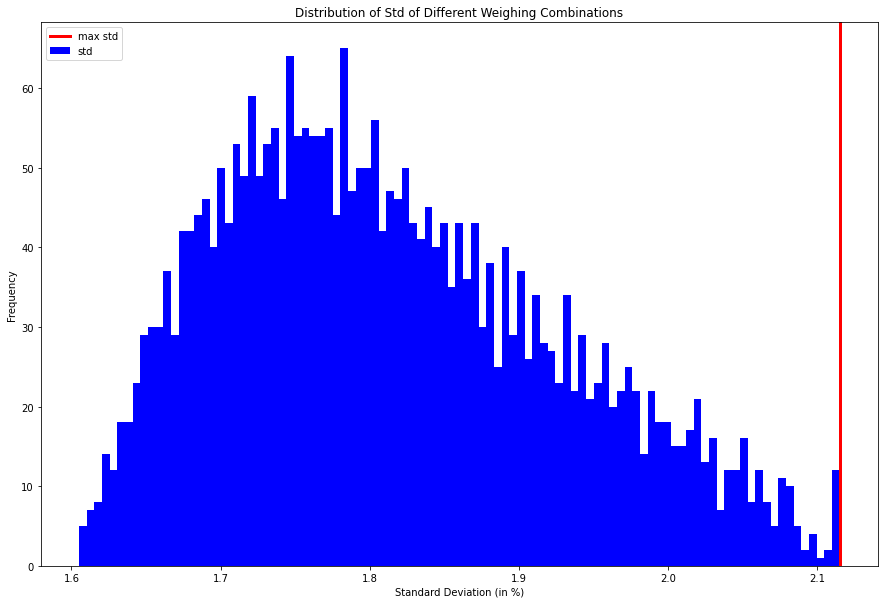

In [20]:
### Use a histogram to show the std of other weightings
# Create the interval classes
bins_max = max(all_std)
bins_min = min(all_std)
bins_intervals = 100
bins = np.linspace(bins_min, bins_max, bins_intervals)

# Create the histogram
plt.rcParams["figure.figsize"] = (15,10)
plt.hist(all_std, bins, color='b', label='std')
plt.axvline(x=max_std, color='r', label='max std', linewidth=3)

# Formatting
plt.title("Distribution of Std of Different Weighing Combinations")
plt.xlabel("Standard Deviation (in %)")
plt.ylabel("Frequency")
plt.legend(loc='best')

# Display
plt.show()

### Step #9: Graphing the change in Portfolio Standard Deviation as we add more stocks into our portfolio

Some may question why we only chose 10 stocks in our portfolio, since in theory, if we chose 20 highly correlated stocks, the standard deviation and overall risk of the portfolio should be amplified by the similar stock movement. However, this is not the case due to diversification which we will exemplify in the graph below.

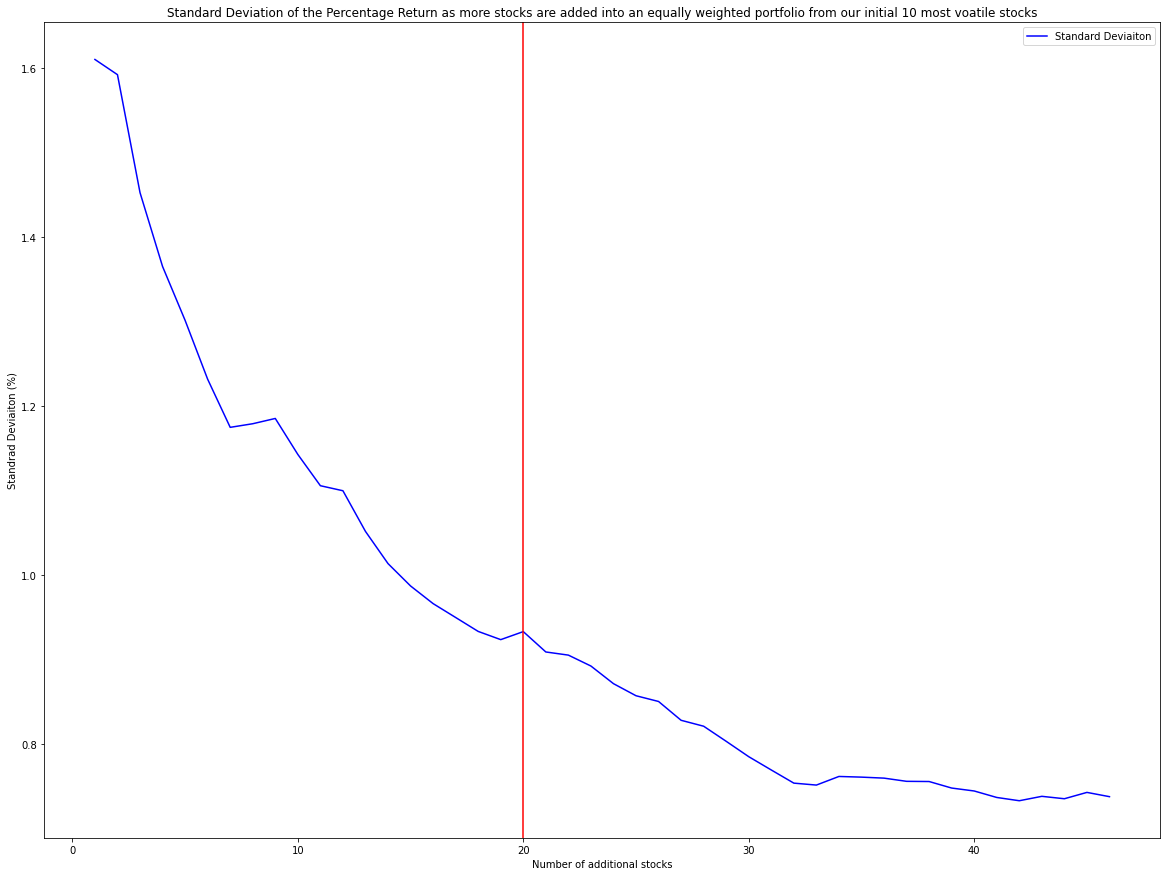

In [21]:
# Take a copy of the filtered stocks, with just the stock names
rest_of_stocks_name = []
for i in filtered_stocks:
    rest_of_stocks_name.append(i.info['symbol'])

# Filter out stocks already included max_corr_lst, and store the remaining
for y in range (len (max_corr_ticker_lst)):
    for u in range (len (rest_of_stocks_name)):
        if (max_corr_ticker_lst[y] == rest_of_stocks_name[u]):
            rest_of_stocks_name.pop(u)
            break # Break this loop, and move on to the next stock

#Array that contains all of the stocks names that will be used later on for reference
all_stock_names = rest_of_stocks_name + max_corr_ticker_lst

#Begin to try to make the code block below recursive
SD_array = []

# Find the std of the portfolio, store in in SD_array for plotting
def find_std(dataframe, num_list_of_stocks):
    portfolio_std = dataframe.pct_change().std()[num_list_of_stocks-1] * 100
    SD_array.append(portfolio_std)

def collect_multiple_std(initial_10, stocks_add_on): #stocks_add_on needs to be rest_of_stocks_name
    global all_price_df
    
    # Get the dataframe consisting of the initial 10 stocks
    shares_10_df = all_price_df[initial_10]

    # First add the portfolio of our chosen 10 stocks, assuming for evenly distributed weights
    equal_weight = [1/len(initial_10)] * len(initial_10)
    intial_10_std = portfolio_cal(initial_10, equal_weight, start_date, end_date)['Percent_Return'].std()
    SD_array.append(intial_10_std)

    # Now make the loop to make more stocks
    current_frame_array = [shares_10_df.copy()]

    for g in range (len (stocks_add_on)):
        next_frame = (pd.DataFrame(all_price_df.loc[:,stocks_add_on[g]]))
        current_frame_array.append(next_frame)
        current_frame = pd.concat(current_frame_array, join='inner',axis=1)
        
        #Amount of money per stock
        money_per_stock = 100000 / len(current_frame.columns)
    
        #Number of shares
        num_shares = []
        for h in range(len(current_frame.columns)):
            num_shares.append(money_per_stock / current_frame.iloc[0,h])
        
        #Create the portfolio value
        portfolio_value = 0
        for k in range(len(current_frame.columns)):
            portfolio_value = portfolio_value + num_shares[k]*current_frame.iloc[:,k]  

        data = {'Date': current_frame.index,
                'Portfolio_Value': portfolio_value}
        
        portfolio_frame = pd.DataFrame(data)
        
        portfolio_dataframe = pd.concat([shares_10_df, portfolio_frame], join='inner', axis=1)
        
        #Drop the duplicate column
        portfolio_dataframe.drop(columns=['Date'], inplace=True)  

        find_std(portfolio_dataframe, len(portfolio_dataframe.columns))
        
collect_multiple_std(max_corr_ticker_lst, rest_of_stocks_name)

nums = []
for k in range (len(SD_array)):
    nums.append(k+1)

# Graphing out portion
plt.figure(figsize=(20,15))

plt.plot(nums, SD_array, color='b', label='Standard Deviaiton')
plt.legend(loc='best')
#Plot where our standard deviaiton will be if we had 20 stocks in our portfolio
plt.axvline(x=20, color='r', label='Standard Deviation for 20 portfolio stock')
plt.title('Standard Deviation of the Percentage Return as more stocks are added into an equally weighted portfolio from our initial 10 most voatile stocks')
plt.xlabel('Number of additional stocks')
plt.ylabel('Standrad Deviaiton (%)')

# Display
plt.show()

The graph above exemplifies an equally weighted portfolio where each stock is allocated an equal amount of money. Hence, in a portfolio with n shares, each stock would be weighted 100/n %. As we move across the x-axis, more stocks are added to the portfolio.

As we can see in the graph above, as more stocks are added to a portfolio, the overall standard deviation decreases exponentially. Note that the standard deviation for a portfolio containing 20 randomly selected stocks is almost half of a portfolio containing only 10 stocks. Such phenomenon occurs due to the effects of diversification; by mixing a wide variety of stocks from all different industries, the portfolio is limiting its exposure to the movements of any single stock. In addition to the daily price movement, diversification protects the portfolio from a variety of risks, including business risk in a particular industry, default risk for companies that are on the fringe, and non-systematic risk related to company-specific news. As more stocks are added to the portfolio, the portfolio becomes less biased to a particular company, industry, or country. 

However, for our portfolio we want it to be as risky and volatile as possible. For this reason, we want our portfolio to be as exposed as possible to the various risks listed earlier. Business risks were taken into consideration by calculating the correlation of the portfolio; stocks that come from the same industry typically have a high correlation and our algorithm searches for the 10 most highly correlated stocks. Non-systematic risks were factored into our portfolio by optimally assigning weighting to each stock to capitalize on its abnormal fluctuations. By doing so, our portfolio is heavily exposed to any fraud, company drama, or CEO scandal related to 1 company which induces volatility. For example, if our algorithm weighted a company such as Tesla 35%, the volatile share price of Tesla induced by an erratic CEO, highly competitive industry, and heavily investigated firm will be reflected in our portfolio. Default risk was not taken into consideration due to the fact that a company that is on the verge of defaulting on their debt most likely has very little volatility; given the poor state of the company, nobody wants to purchase the stock resulting in a relatively low fixated price.

In the ways above, our portfolio has taken into consideration the various risks that induce volatility in a portfolio.

To demonstrate the riskiness of our portfolio, we will compare it to other indexes and portfolio by calculating the Beta value. Given that we want the highest volatility possible, we wish to get as high of a Beta Value as possible.

### Step #10: Beta with S&P 500

We will compare the Beta of our portfolio with reference to the S&P500. Theoretically, our beta should be higher than 1, signaling its volatility when compared to the broader market.

In [22]:
#The portfolio that we created
Our_portfolio = portfolio_cal(max_corr_ticker_lst, optimal_weights, start_date, end_date)

# Using the S&P 500 as the market index
MarketIndex = '^GSPC'

# Use a new df to store the portfolio value and the market value
prices = pd.DataFrame(Our_portfolio['Portfolio_Value'])
prices.columns = ['Our_Portfolio']
MarketIndex_hist = yf.Ticker(MarketIndex).history(start=start_date, end=end_date)
prices[MarketIndex] = MarketIndex_hist['Close']

# Calculate the daily returns
daily_returns = prices.pct_change()
daily_returns.drop(index = daily_returns.index[0], inplace=True)

# Calculat the market variance and beta
MarketVar = daily_returns[MarketIndex].var()
Beta = daily_returns.cov()/MarketVar

# Display of statistics
print(Beta)
print('The Beta of our portfolio is: ', Beta.iat[0,1])
print("This means our portfolio is ",(Beta.iat[0,1]-1)*100,"% more volatile than the S&P500")

               Our_Portfolio     ^GSPC
Our_Portfolio       8.586467  1.614481
^GSPC               1.614481  1.000000
The Beta of our portfolio is:  1.6144809507338866
This means our portfolio is  61.448095073388664 % more volatile than the S&P500


From the Beta value above, our portfolio is significantly more volatile than the S&P500 index. This means that in comparison to the overall market, our portfolio is more volatile, which is a good indicator.

This value is in line with diversification as the S&P500 is constituted of 500 different shares while our portfolio is only constituted of 10.

### Step #11: Calculate the Beta between our portfolio and an equally weighted portfolio including all valid stocks.

We will create a portfolio of all given valid US tickers with equally distributed weights. This will serve as another benchmark of the market, much like the S&P 500. This analysis is necessary because we need to show that our chosen portfolio outperforms the market of all stocks provided, thus proving our selection of stocks is effective.

In [23]:
# Function that creates a equally weighted portfolio given the ticker list
def make_equal_weighted_portfolio(list_of_stocks):
    # Load the global dataframe
    global all_price_df

    closing_prices_of_stocks = []
    for g in list_of_stocks:
        closing_prices_of_stocks.append(pd.DataFrame(all_price_df.loc[:,g])) #converted to just a loc

    # A dataframe that contains the price of all considered tickers
    pwindex = pd.concat(closing_prices_of_stocks, join='inner', axis=1)

    amount_per_stock = 100000 / len(pwindex.columns)

    # Calculating the shares purchased for each stock
    num_shares = []
    for r in range (len(pwindex.columns)):
        num_shares.append(amount_per_stock/pwindex.iloc[0,r])
    
    # Calculating the portfolio value
    portfolio_values = []
    for i in range (len (pwindex.index)):
        p=0
        for u in range (len (pwindex.columns)):
            p = p + pwindex.iloc[i,u] * num_shares[u]
        portfolio_values.append (p)
    
    data = {'Date': pwindex.index,
            'Value': portfolio_values}

    data_df = pd.DataFrame(data)
    data_df.set_index('Date', inplace=True)

    return data_df

# Calculate the equally-weight portfolio consisting of all valid stocks
data_df = make_equal_weighted_portfolio(all_stock_names)

# Reformatting columns, for later output purposes
prices = pd.DataFrame(Our_portfolio['Portfolio_Value'])
prices.columns = ['Our_Portfolio']
prices['Equal_Weighted_Index'] = data_df['Value']

# Calculate the market variance and Beta
daily_returns = prices.pct_change()
daily_returns.drop(index = daily_returns.index[0], inplace=True)
MarketVar = daily_returns['Equal_Weighted_Index'].var()
Beta = daily_returns.cov()/MarketVar

# Display
print(Beta)
print('The Beta of our portfolio is: ', Beta.iat[0,1])
print("This means our portfolio is ",(Beta.iat[0,1]-1)*100,"% more volatile than the equally weighted index including all valid stocks")

                      Our_Portfolio  Equal_Weighted_Index
Our_Portfolio              8.222641              2.154248
Equal_Weighted_Index       2.154248              1.000000
The Beta of our portfolio is:  2.1542479767655456
This means our portfolio is  115.42479767655456 % more volatile than the equally weighted index including all valid stocks


As we notice from the Beta calculation above, our portfolio should be significantly more volatile than an equally weighted portfolio including all valid stocks from the CSV file.

### Step #12: Beta in reference to the price-weighted index of given stocks

Now we create another benchmark portfolio of all provided tickers such that the portfolio is price weighted. Similar arguments apply, which is to demonstrate the optimal characteristics of our final chosen portfolio.

In [24]:
closing_prices_of_stocks = []
for g in all_stock_names:
    closing_prices_of_stocks.append(pd.DataFrame(all_price_df.loc[:,g]))

# A dataframe that contains the price of all considered tickers
pwindex = pd.concat(closing_prices_of_stocks, join='inner', axis=1)

# Calculation of the index
pwindex['PWIndex_Value'] = pwindex.sum(axis=1)
pwindex['PWIndex_Value'] /= (len(pwindex.columns)-1)

# Reformatting columns, for later output purposes
prices = pd.DataFrame(Our_portfolio['Portfolio_Value'])
prices.columns = ['Our_Portfolio']
prices['Price_Weighted_Index'] = pwindex['PWIndex_Value']

# Calculate the market variance and Beta
daily_returns = prices.pct_change()
daily_returns.drop(index = daily_returns.index[0], inplace=True)
MarketVar = daily_returns['Price_Weighted_Index'].var()
Beta = daily_returns.cov()/MarketVar

# Display
print(Beta)
print('The Beta of our portfolio is: ', Beta.iat[0,1])
print("This means our portfolio is ",(Beta.iat[0,1]-1)*100,"% more volatile than the price weighted index including all valid stocks")

                      Our_Portfolio  Price_Weighted_Index
Our_Portfolio              6.345017              1.132433
Price_Weighted_Index       1.132433              1.000000
The Beta of our portfolio is:  1.132433028986257
This means our portfolio is  13.243302898625696 % more volatile than the price weighted index including all valid stocks


In a price-weighted index, there is a possibility that some tickers will have a weighting greater than 35% due to the fact that the weighting is determined by a share's price. For instance, if one of our valid stocks was Berkshire Hathaway, our portfolio value will be single-handedly influenced by Hathaway given its massive price and weighting. 

Despite the unequal weighting with no limitation, our portfolio was still more volatile exemplifying the high correlation of stocks in our portfolio; if our stocks were not highly correlated, then the percentage of price change in a single heavily weighted stock should outweigh the overall percent change in our portfolio.

### Step #13: Beta between our portfolio with varied weight versus when it is equally weighted

Here, we will hypothetically create a market, such that it is represented by an equally weighted portfolio of the 10 chosen stocks. Hence, we will evaluate our varied-weighted portfolio against this benchmark, to demonstrate the benefit of dynamically varying the weights.

In [25]:
### Compare Beta between our portfolio and an equally weighted 10 portfolio
equal_10 = make_equal_weighted_portfolio(max_corr_ticker_lst)

# Reformatting columns, for later output purposes
prices = pd.DataFrame(Our_portfolio['Portfolio_Value'])
prices.columns = ['Our_Portfolio']
prices['Equal_Weighted_Index_10'] = equal_10['Value']

# Calculate the market variance and Beta
daily_returns = prices.pct_change()
daily_returns.drop(index = daily_returns.index[0], inplace=True)
MarketVar = daily_returns['Equal_Weighted_Index_10'].var()
Beta = daily_returns.cov()/MarketVar

# Display
print(Beta)
print('The Beta of our portfolio is: ', Beta.iat[0,1])
print("This means our portfolio is ",(Beta.iat[0,1]-1)*100,"% more volatile than the equally weighted index only including the 10 stocks chosen for our portfolio")

                         Our_Portfolio  Equal_Weighted_Index_10
Our_Portfolio                 1.726386                 1.254586
Equal_Weighted_Index_10       1.254586                 1.000000
The Beta of our portfolio is:  1.2545862976321658
This means our portfolio is  25.458629763216578 % more volatile than the equally weighted index only including the 10 stocks chosen for our portfolio


The beta value above suggests that our portfolio is more volatile than an equally weighted portfolio of the 10 most volatile and highly correlated stocks. From such observation, we can note that the weighting for our stocks was done correctly; had the weightings of the 10 shares chosen were not optimized for volatility, the diversification of having 10 different shares would decrease the overall standard deviation.

### Conclusion from All Previous BETA-related Analysis
As seen from the past 4 Beta calculations, our portfolio is significantly riskier than a randomly chosen number of stocks, meaning that our portfolio effectively accumulated a highly volatile portfolio.

### Step #14: Compare our portfolio graphically against an equally weighted index containing only the 10 stocks chosen

Lastly, to **GRAPHICALLY** compare our portfolio against the equally weighted portfolio containing only the 10 stocks chosen, we will first need to generate our portfolio first so we can then graph and compare the portfolio over the time frame from July 2, 2021, to October 22, 2021.

In [26]:
# Load in our portfolio with varied weights
varied_w = Our_portfolio[['Portfolio_Value']].rename(columns={'Portfolio_Value' : 'Our_Portfolio'})
equal_w = equal_10[['Value']].rename(columns={'Value' : 'Equal_Weight'})

# Create the combined dataframe of our portfolio and the equally weighted one
ours_and_equally_weighted = pd.concat([varied_w, equal_w], join = 'inner', axis = 1)

# Short display
ours_and_equally_weighted.head()

,Our_Portfolio,Equal_Weight
Date,,
2021-07-02,100000.000000,100000.000000
2021-07-06,95651.315068,97090.996829
2021-07-07,94003.325289,96289.632353
2021-07-08,93373.604454,94881.680053
2021-07-09,95824.390958,97909.990869


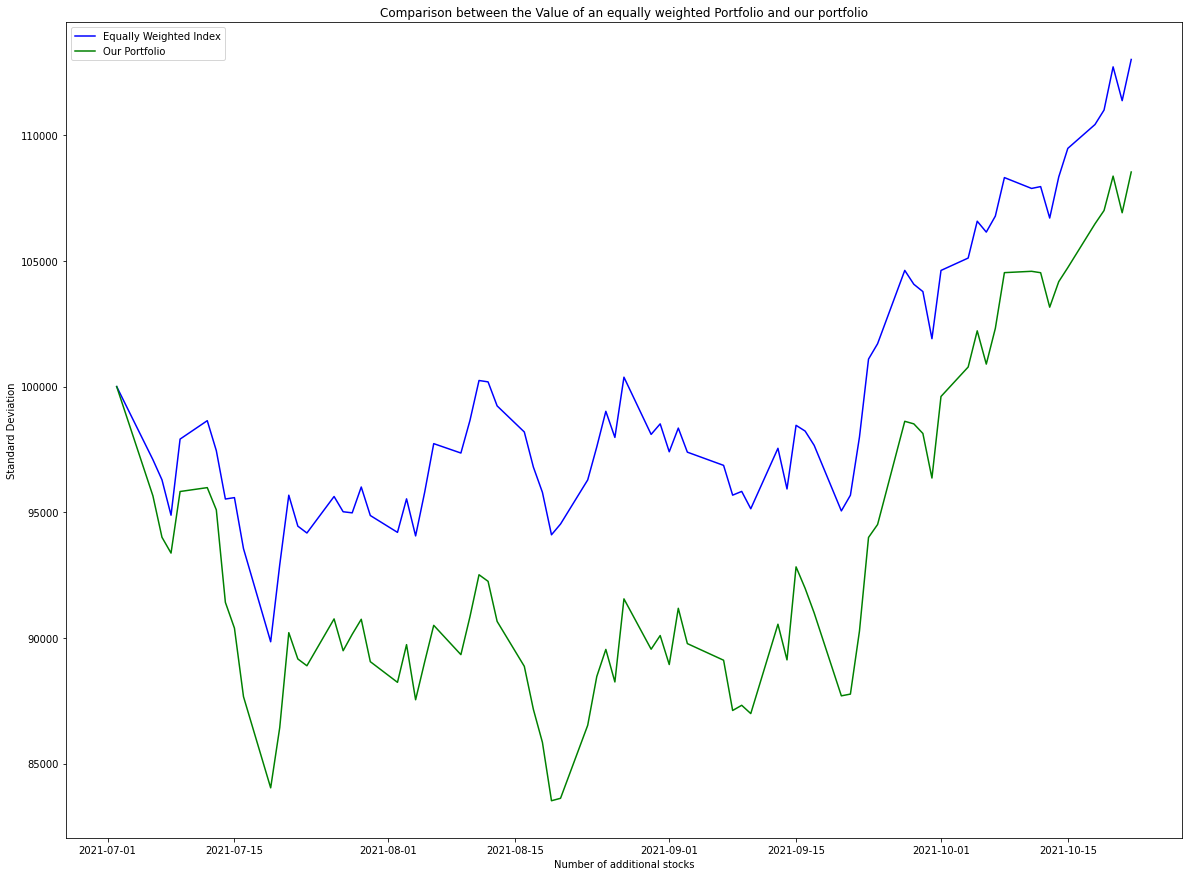

In [27]:
# Graphing out portion
plt.figure(figsize=(20,15))

plt.plot(ours_and_equally_weighted.index, ours_and_equally_weighted['Equal_Weight'], color='b', label='Equally Weighted Index') 
plt.plot(ours_and_equally_weighted.index, ours_and_equally_weighted['Our_Portfolio'], color='g', label = "Our Portfolio")
plt.legend(loc='best')
plt.title('Comparison between the Value of an equally weighted Portfolio and our portfolio')
plt.xlabel('Number of additional stocks')
plt.ylabel('Standard Deviation')

# Display
plt.show()

As we can see in the graph above, while following the general trend, the price movement in our portfolio is significantly more acute than our equally weighted portfolio, when observing the fluctuation from the starting value. As seen, if the portfolio were to be chased out at any point in time, the overall volatility of our portfolio is significantly higher.

## Part #4: Final Output

### Step #15: Creating the final portfolio dataframe and csv

In [28]:
# Define important variables
final_tickers = max_corr_ticker_lst
final_weights = optimal_weights
investment = 100000
required_date = '2021-11-26'
next_date = '2021-11-27' # Used as the end_date parameter

# Access the price on the required date
def price_on_date(ticker, date, next_date):
    return yf.Ticker(ticker).history(start=date, end=next_date)[['Close']].iloc[0,0]

# Get the price, share, value, weight of the ticker on required date
price = []
value = []
share = []
weight = []
for i in range (len(final_tickers)):
    price.append(price_on_date(str(final_tickers[i]), required_date, next_date))
    value.append(investment * final_weights[i])
    share.append(value[i] / price[i])
    weight.append(final_weights[i] * 100)
    

# Create a diction to store the required info
final_dic = {'Ticker' : final_tickers,
             'Price'  : price,
             'Shares' : share,
             'Value'  : value,
             'Weight' : weight}

# Create the final df
FinalPortfolio = pd.DataFrame(final_dic)
# Shift the index
FinalPortfolio.index = np.arange(1, len(FinalPortfolio)+1)

In [29]:
# Show that value adds to $100,000, the weights add to 100%
sum_value = FinalPortfolio['Value'].sum()
sum_weight = FinalPortfolio['Weight'].sum()
print(f'The sum of all Value is ${sum_value}.')
print(f'The sum of all Weight is {sum_weight}%.')

The sum of all Value is $100000.0.
The sum of all Weight is 100.0%.


In [30]:
# Creating the output csv
Stocks = FinalPortfolio[['Ticker', 'Shares']]
Stocks.to_csv('Stocks_Group_17.csv')

In [31]:
# Display the final portfolio
FinalPortfolio

,Ticker,Price,Shares,Value,Weight
1,OXY,30.639999,1142.297673,35000.0,35.0
2,SLB,31.860001,784.682973,25000.0,25.0
3,COP,72.720001,68.756875,5000.0,5.0
4,COF,152.990005,32.681873,5000.0,5.0
5,AIG,56.119999,89.094799,5000.0,5.0
6,SPG,169.380005,29.519423,5000.0,5.0
7,AXP,176.210007,28.375233,5000.0,5.0
8,BAC,46.320000,107.944733,5000.0,5.0
9,USB,58.650002,85.251490,5000.0,5.0
10,BK,57.770000,86.550112,5000.0,5.0


## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

John Huang, Gen Nishiwaki